In [1]:
from pycorr import TwoPointCorrelationFunction
import numpy as np
from pathlib import Path
from scipy import stats
import matplotlib.pyplot as plt

import scienceplots
plt.style.use('science')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
data_dir = Path('/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/sunbird/emc/')
covariance_path = data_dir / 'covariance/tpcf/z0.5/yuan23_prior/'

# Let's read 1000 tpcfs generated from the c0 small boxes for covariance estimation
n_for_covariance = 1_000
covariance_files = list(covariance_path.glob('*.npy'))[:n_for_covariance]


print(f'Reading {len(covariance_files)} covariance files')
covariance_y = np.array(
    [
        TwoPointCorrelationFunction.load(file)[:-72][::4](ells=(0,2),).reshape(-1) for file in covariance_files
    ]
)


Reading 1000 covariance files


In [4]:
s, _ = TwoPointCorrelationFunction.load(covariance_files[0])[:-72][::4](ells=(0,2), return_sep=True)

In [5]:
mean_y = np.mean(covariance_y,axis=0)

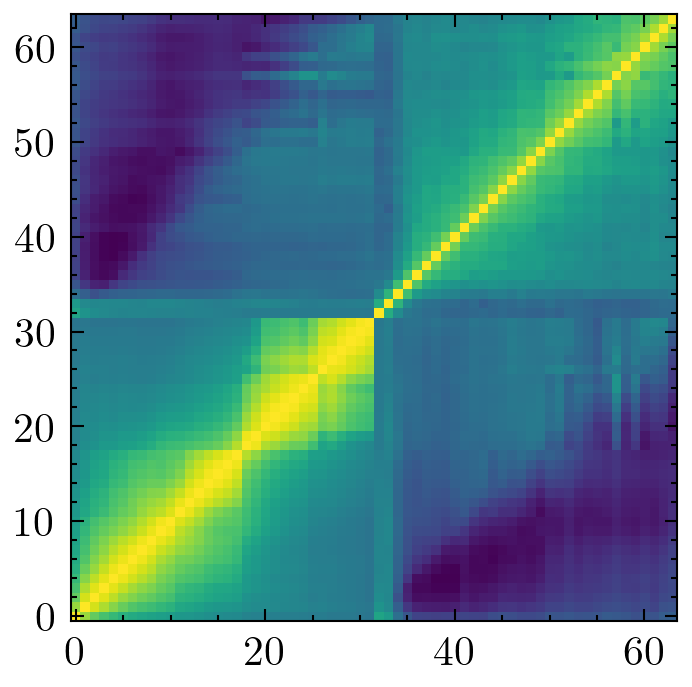

In [6]:
covariance_matrix = np.cov(covariance_y.T)

correlation_matrix = np.corrcoef(covariance_y.T)
inverse_covariance = np.linalg.solve(
    covariance_matrix, np.eye(len(covariance_matrix), len(covariance_matrix))
)
plt.imshow(correlation_matrix, origin='lower')

<ErrorbarContainer object of 3 artists>

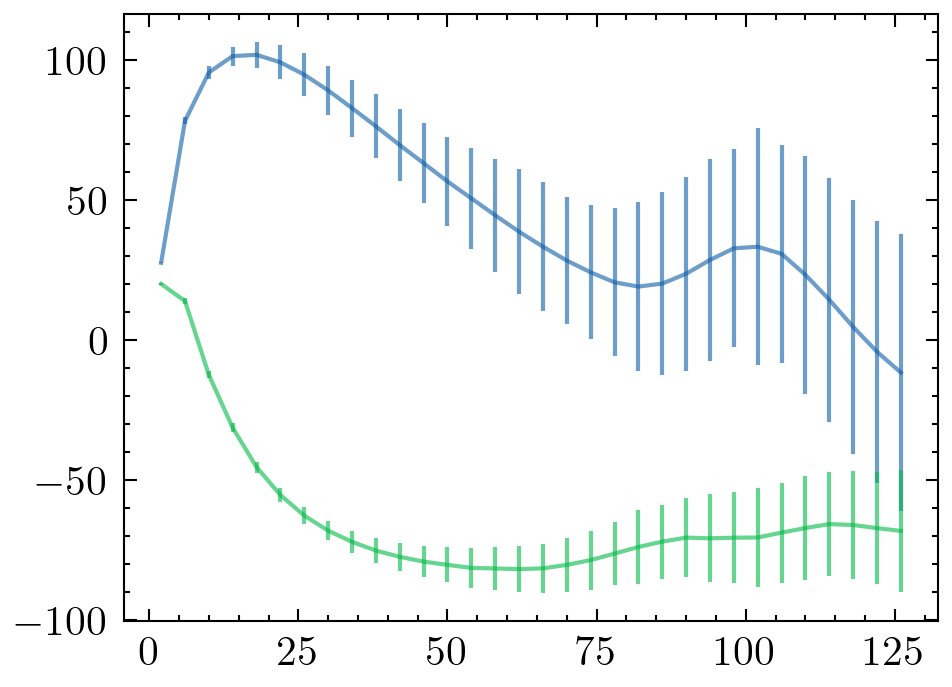

In [7]:


plt.errorbar(
    s, 
    s**2*mean_y[:len(s)],
    yerr=s**2*np.sqrt(np.diag(covariance_matrix)[:len(s)]),
    alpha=0.6,
)

plt.errorbar(
    s, 
    s**2*mean_y[len(s):],
    yerr=s**2*np.sqrt(np.diag(covariance_matrix)[len(s):]),
    alpha=0.6,
)

In [8]:

# Get another independnet ~700 samples from the small boxes
covariance_files = list(covariance_path.glob('*.npy'))[n_for_covariance:n_for_covariance + 700]


samples_y = np.array(
    [
        TwoPointCorrelationFunction.load(file)[:-72][::4](ells=(0,2),).reshape(-1) for file in covariance_files
    ]
)


In [9]:

def compute_xi2(vector, mean, inverse_covariance):
    return (vector - mean) @ inverse_covariance @ (vector - mean).T


def sample_from_multigaussian(mean, covariance, n_samples):
    return np.random.multivariate_normal(mean, covariance, size=n_samples)

# sample from a multivariate gaussian with the estimated mean and covariance
generated_y = sample_from_multigaussian(
    mean_y,
    covariance_matrix,
    n_samples=len(samples_y),
)

In [10]:
# compute the xi2 value for each of the measured tpcf in the covariance boxes
xi2_data = np.array([compute_xi2(fid, mean_y, inverse_covariance) for fid in samples_y])

# compute the xi2 value for each of the measured tpcf in the covariance boxes
xi2_random = np.array([
    compute_xi2(fid, mean_y, inverse_covariance) for fid in generated_y 
])
dof = samples_y.shape[1]

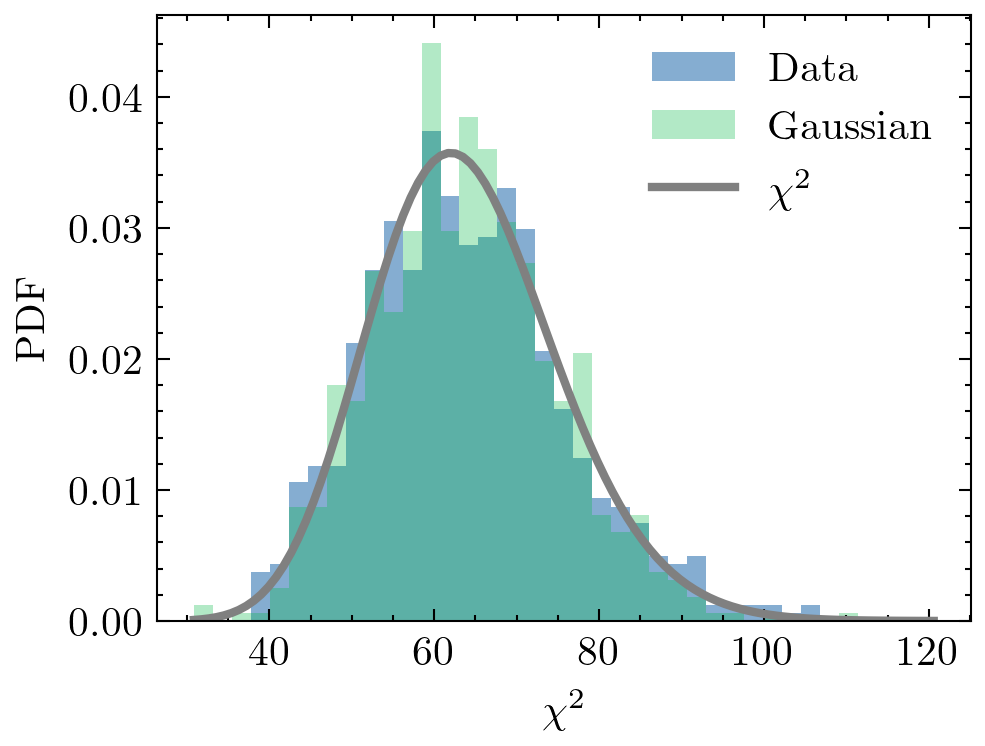

In [11]:
x_fine = np.linspace(np.min(xi2_random), 1.1*np.max(xi2_random), 100)
x_coarse = np.linspace(np.min(xi2_random), 1.1*np.max(xi2_random), 40)

fig, ax = plt.subplots()
bins = ax.hist(
    xi2_data,
    bins=x_coarse,
    density=True,
    label="Data",
    alpha=0.5,
    edgecolor=None,
    # color=colors[0],
)
ax.hist(
    xi2_random,
    bins=x_coarse,
    density=True,
    alpha=0.3,
    label="Gaussian",
    edgecolor=None,
)
ax.plot(x_fine, stats.chi2.pdf(x_fine, dof), label=r"$\chi^2$", color="gray", linewidth=2)
ax.set_xlabel(
        r"$\chi^2$",
    )
ax.set_ylabel(
    r"$\mathrm{PDF}$",
)
plt.legend()


In [12]:
def qq_plot(data,  dof):
    # Calculate the quantiles of the chi-squared distribution
    theoretical_quantiles = np.percentile(stats.chi2.rvs(dof, size=1_000), np.linspace(0, 100, num=len(data)))
    empirical_quantiles = np.sort(data)
    return theoretical_quantiles, empirical_quantiles


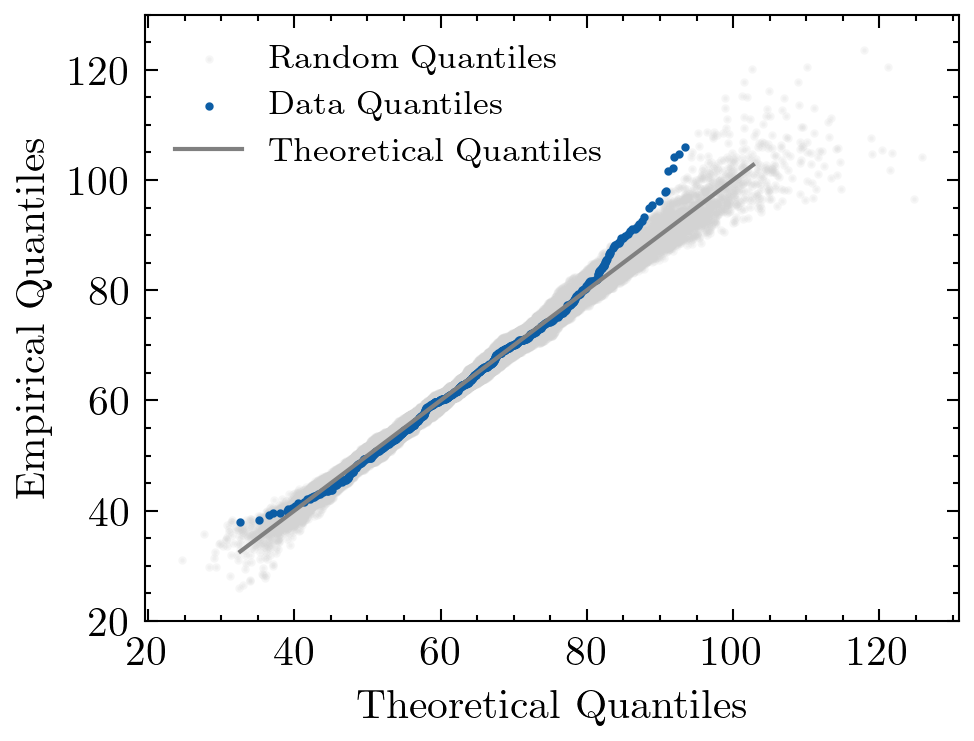

In [13]:
# Create a Q-Q plot
for i in range(100):
    generated_y = sample_from_multigaussian(
        mean_y,
        covariance_matrix,
        n_samples=len(samples_y),
    )
    xi2_random = np.array([
        compute_xi2(fid, mean_y, inverse_covariance) for fid in generated_y 
    ])
    theoretical_quantiles, random_quantiles = qq_plot(xi2_random, dof)
    plt.scatter(theoretical_quantiles, random_quantiles,  label="Random Quantiles" if i==0 else None, s=1, color='lightgray', alpha=0.2)
theoretical_quantiles, data_quantiles = qq_plot(xi2_data, dof)
plt.scatter(theoretical_quantiles, data_quantiles,  label="Data Quantiles", s=1)
plt.plot(theoretical_quantiles, theoretical_quantiles,  label="Theoretical Quantiles", color='gray')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Empirical Quantiles")
plt.ylim(20,130)
plt.legend(fontsize=8)
plt.show()